<a href="https://colab.research.google.com/github/toyinjoy/Descriptive-Learning-Project/blob/main/Projeto_Aprendizado_Descritivo_Eclat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptive Learning with Eclat
This notebook is part of a project exploring frequent pattern mining and subgroup discovery on hospitalization data from Brazil’s Unified Health System (SUS). Using Eclat algorithm from PyFim and WRAcc-based subgroup discovery, we identified meaningful patterns and patient segments associated with mortality, cost, and length of stay.

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Instalando o kagglehub se ainda não estiver instalado
!pip install kagglehub --quiet

# Fazendo o download do dataset BigSUS SIH Silver (base hospitalar do SUS)
import kagglehub

# Baixando o dataset
path = kagglehub.dataset_download("victoremanuel/bigsus-sih-silver")

# Exibindo o caminho dos arquivos baixados
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bigsus-sih-silver


In [3]:
# Filtrando dados de interesse a ser analisada

pastas_validas = []

for p in sorted(os.listdir(path)):
    if p.isdigit() and int(p) >= 201901:
        pasta_completa = os.path.join(path, p)
        if os.path.isdir(pasta_completa):
            arquivos = [f for f in os.listdir(pasta_completa) if f.endswith(".parquet")]
            if arquivos:
                pastas_validas.append(p)

In [4]:
# Selecionando apenas as colunas a serem utilizadas
colunas = [
    "SEXO", "IDADE", "CAR_INT", "UF_ZI",
    "DIAG_PRINC", "MORTE", "DIAS_PERM", "VAL_TOT"
]

In [5]:
# Criando o dataframe para exploração dos dados
dfs = []

for pasta in pastas_validas:
    caminho_pasta = os.path.join(path, pasta)
    arquivos = [f for f in os.listdir(caminho_pasta) if f.endswith(".parquet")]

    for arquivo in arquivos:
        caminho_arquivo = os.path.join(caminho_pasta, arquivo)
        print(f"Lendo {caminho_arquivo}")
        df = pd.read_parquet(caminho_arquivo, columns=colunas)
        dfs.append(df)

# Concatena todos os dados reduzidos
df_filtrado = pd.concat(dfs, ignore_index=True)

Lendo /kaggle/input/bigsus-sih-silver/201901/RDSP1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDPB1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDPR1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDAM1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDMG1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDMT1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDRN1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDRS1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDRO1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDAC1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDRJ1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDMA1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDPE1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDRR1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDBA1901.parquet
Lendo /kaggle/input/bigsus-sih-silver/201901/RDAP1901.parquet
Lendo /k

In [6]:
# Força conversão de Valor Total para número
df_filtrado["VAL_TOT"] = pd.to_numeric(df_filtrado["VAL_TOT"], errors="coerce")

In [7]:
# Obtendo descrição estatística dos dados
df_filtrado.describe()

,IDADE,MORTE,DIAS_PERM,VAL_TOT
count,7.926896e+07,7.926896e+07,7.926896e+07,7.926896e+07
mean,4.211380e+01,4.918813e-02,5.188668e+00,1.587498e+03
std,2.424350e+01,2.162606e-01,7.523166e+00,3.998602e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.300000e+01,0.000000e+00,1.000000e+00,3.568100e+02
50%,4.000000e+01,0.000000e+00,3.000000e+00,6.285700e+02
75%,6.200000e+01,0.000000e+00,6.000000e+00,1.139600e+03
max,9.900000e+01,1.000000e+00,3.640000e+02,2.742075e+05


In [8]:
# Verificando informações do dataset gerado
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79268957 entries, 0 to 79268956
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SEXO        object 
 1   IDADE       int8   
 2   CAR_INT     object 
 3   UF_ZI       object 
 4   DIAG_PRINC  object 
 5   MORTE       int8   
 6   DIAS_PERM   int32  
 7   VAL_TOT     float64
dtypes: float64(1), int32(1), int8(2), object(4)
memory usage: 3.4+ GB


In [9]:
# Verificando existência de valores nulos
df_filtrado.isnull().sum()

,0
SEXO,0
IDADE,0
CAR_INT,0
UF_ZI,0
DIAG_PRINC,0
MORTE,0
DIAS_PERM,0
VAL_TOT,0


In [10]:
# Avaliando quantidade de valores únicos
df_filtrado.nunique()

,0
SEXO,2
IDADE,100
CAR_INT,6
UF_ZI,2454
DIAG_PRINC,10438
MORTE,2
DIAS_PERM,351
VAL_TOT,2176154


In [11]:
# Definição das categorias para variáveis idade, dias de permanência e valor de internação
bins_idade = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 150]
labels_idade = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

bins_perm = [0, 1, 3, 7, 15, 30, 999]
labels_perm = ["1","2-3","4-7","8-15","16-30","31+"]

bins_valor = [0, 1000, 3000, 10000, 30000, 9999999]
labels_valor = ["0-999","1K-3K","3K-10K","10K-30K","30K+"]

In [12]:
# Categorizando colunas numéricas
df_filtrado["IDADE_CAT"] = pd.cut(df_filtrado["IDADE"], bins=bins_idade, labels=labels_idade, right=False)
df_filtrado["PERM_CAT"] = pd.cut(df_filtrado["DIAS_PERM"], bins=bins_perm, labels=labels_perm, right=False)
df_filtrado["VAL_CAT"] = pd.cut(df_filtrado["VAL_TOT"], bins=bins_valor, labels=labels_valor, right=False)

In [13]:
df_filtrado.head()

,SEXO,IDADE,CAR_INT,UF_ZI,DIAG_PRINC,MORTE,DIAS_PERM,VAL_TOT,IDADE_CAT,PERM_CAT,VAL_CAT
0,1,38,01,350950,S826,0,2,634.56,30-39,2-3,0-999
1,1,1,02,350950,P229,0,8,3328.72,0-9,8-15,3K-10K
2,1,1,02,350950,P229,0,3,262.54,0-9,4-7,0-999
3,3,72,01,350950,M064,0,1,1229.70,70-79,2-3,1K-3K
4,3,15,01,350950,Q668,0,2,903.24,10-19,2-3,0-999


In [14]:
df_filtrado.shape

(79268957, 11)

#Frequent Pattern Mining

In [15]:
!pip install pyfim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfim: filename=pyfim-6.28-cp311-cp311-linux_x86_64.whl size=647119 sha256=0ab43dff88480d8e311fd080daaa456ed3adefa7b366eda3e22bd183f68d8d67
  Stored in directory: /root/.cache/pip/wheels/aa/a6/5e/b106c510135fd055b238ecf87738098dc7ad3a1f056dd5208e
Successfully built pyfim


In [16]:
!pip install --quiet mlxtend pandas numpy

In [17]:
from fim import eclat

In [18]:
import pandas as pd


In [19]:
# 3% sample of 79M = ~2.37M rows
df_sample = df_filtrado.sample(frac=0.03, random_state=42)
print(df_sample.shape)


(2378069, 11)


In [20]:

def row_to_items(row):
    return [
        f"SEXO={row['SEXO']}",
        f"IDADE={row['IDADE_CAT']}",
        f"CARE={row['CAR_INT']}",
        f"STATE={row['UF_ZI']}",
        f"DX={row['DIAG_PRINC']}",
        f"LOS={row['PERM_CAT']}",
        f"COST={row['VAL_CAT']}"
        #f"MORT={row['MORTE']}",
    ]

transactions = df_sample.apply(row_to_items, axis=1).tolist()



In [62]:


min_supp = int(0.00001 * len(transactions))


patterns = eclat(
    transactions,
    supp=min_supp,         # absolute support count
    zmin=2,                # min items in pattern
    zmax=5,                # max items in pattern
    report='aS'            # return (items, absolute support, relative support)
)


In [63]:
print("Total patterns found:", len(patterns))   # likely 0


Total patterns found: 11


In [64]:

print("Top 10 frequent patterns:")
for items, count, support in patterns[:10]:
    print(f"{items} → support: {support:.4f} ({count} rows)")


Top 10 frequent patterns:
('COST=0-999', 'CARE=02') → support: 56.4556 (1342554 rows)
('SEXO=3', 'CARE=02') → support: 44.9778 (1069604 rows)
('SEXO=3', 'COST=0-999', 'CARE=02') → support: 35.1410 (835678 rows)
('SEXO=3', 'COST=0-999') → support: 42.8755 (1019608 rows)
('SEXO=1', 'CARE=02') → support: 32.3529 (769374 rows)
('SEXO=1', 'COST=0-999') → support: 27.8699 (662766 rows)
('LOS=2-3', 'CARE=02') → support: 28.9999 (689637 rows)
('LOS=2-3', 'COST=0-999', 'CARE=02') → support: 25.6480 (609926 rows)
('LOS=2-3', 'COST=0-999') → support: 32.9935 (784609 rows)
('LOS=2-3', 'SEXO=3') → support: 25.9252 (616519 rows)


In [24]:
mortal_patterns = [p for p in patterns if 'MORT=1' in p[0]]
for items, count, support in mortal_patterns[:10]:
    print(f"{items} → support: {support:.4f} ({count} rows)")


In [25]:
# Keep only rows where patient died
df_mort = df_filtrado[df_filtrado['MORTE'] == 1]

# Convert to transactions
transactions_mort = df_mort.apply(row_to_items, axis=1).tolist()

# Mine just within this subset
patterns_mort = eclat(transactions_mort, supp=20, zmin=2, zmax=5, report='aS')

print("Top mortality-only patterns:")
for items, count, support in patterns_mort[:10]:
    print(f"{items} → support: {support:.4f} ({count} rows)")


Top mortality-only patterns:
('SEXO=1', 'CARE=02') → support: 49.2510 (1920343 rows)
('SEXO=3', 'CARE=02') → support: 42.7548 (1667049 rows)
('COST=0-999', 'CARE=02') → support: 37.2928 (1454079 rows)
('COST=0-999', 'SEXO=1') → support: 20.6552 (805365 rows)
('COST=1K-3K', 'CARE=02') → support: 24.7675 (965706 rows)
('LOS=4-7', 'CARE=02') → support: 23.9987 (935731 rows)
('LOS=8-15', 'CARE=02') → support: 23.5103 (916687 rows)
('IDADE=70-79', 'CARE=02') → support: 21.6978 (846019 rows)
('LOS=2-3', 'CARE=02') → support: 20.7394 (808649 rows)


In [26]:
df_mort.shape

(3899092, 11)

In [27]:
print("Total patterns found:", len(patterns_mort))


Total patterns found: 9


In [28]:
# Keep only rows where patient survived
df_survived= df_filtrado[df_filtrado['MORTE'] == 0]




In [29]:
df_surv_sample = df_survived.sample(frac=0.4, random_state=42)
print(df_surv_sample.shape)

(30147946, 11)


In [30]:
# Convert to transactions
transactions_surv_sample = df_surv_sample.apply(row_to_items, axis=1).tolist()

# Mine just within this subset
patterns_surv_sample = eclat(transactions_surv_sample ,supp=20, zmin=2, zmax=5, report='aS')

print("Top Surviving-only patterns:")
for items, count, support in patterns_surv_sample[:10]:
    print(f"{items} → support: {support:.4f} ({count} rows)")

Top Surviving-only patterns:
('COST=0-999', 'CARE=02') → support: 57.4474 (17319225 rows)
('SEXO=3', 'CARE=02') → support: 45.0949 (13595173 rows)
('SEXO=3', 'COST=0-999', 'CARE=02') → support: 36.0302 (10862372 rows)
('SEXO=3', 'COST=0-999') → support: 44.0882 (13291692 rows)
('SEXO=1', 'CARE=02') → support: 31.4825 (9491339 rows)
('SEXO=1', 'COST=0-999', 'CARE=02') → support: 21.4172 (6456853 rows)
('SEXO=1', 'COST=0-999') → support: 28.2387 (8513398 rows)
('LOS=2-3', 'CARE=02') → support: 29.4471 (8877696 rows)
('LOS=2-3', 'COST=0-999', 'CARE=02') → support: 26.3471 (7943124 rows)
('LOS=2-3', 'COST=0-999') → support: 34.0189 (10255993 rows)


In [31]:
print("Total patterns found:", len(patterns_surv_sample))

Total patterns found: 15


In [32]:
cols = ['items', 'count', 'support']
df_pat_mort = pd.DataFrame(patterns_mort, columns=cols)
df_pat_surv = pd.DataFrame(patterns_surv_sample, columns=cols)

In [33]:
df_pat_mort.head()

,items,count,support
0,"(SEXO=1, CARE=02)",1920343,49.251031
1,"(SEXO=3, CARE=02)",1667049,42.754800
2,"(COST=0-999, CARE=02)",1454079,37.292759
3,"(COST=0-999, SEXO=1)",805365,20.655194
4,"(COST=1K-3K, CARE=02)",965706,24.767459


In [34]:
df_pat_surv.head()

,items,count,support
0,"(COST=0-999, CARE=02)",17319225,57.447446
1,"(SEXO=3, CARE=02)",13595173,45.094857
2,"(SEXO=3, COST=0-999, CARE=02)",10862372,36.030222
3,"(SEXO=3, COST=0-999)",13291692,44.088217
4,"(SEXO=1, CARE=02)",9491339,31.482539


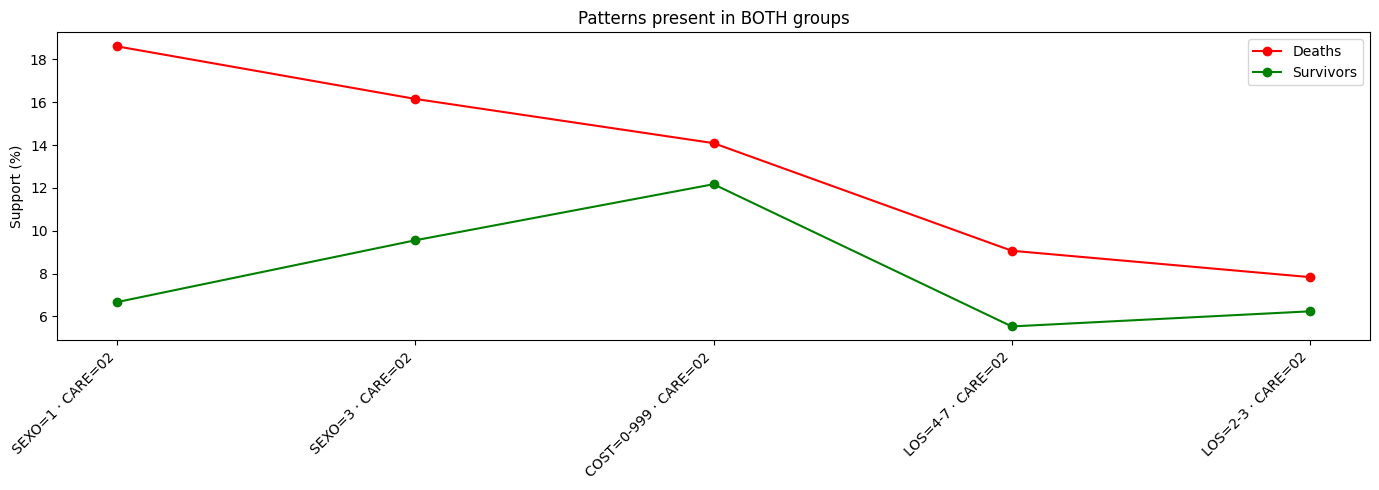

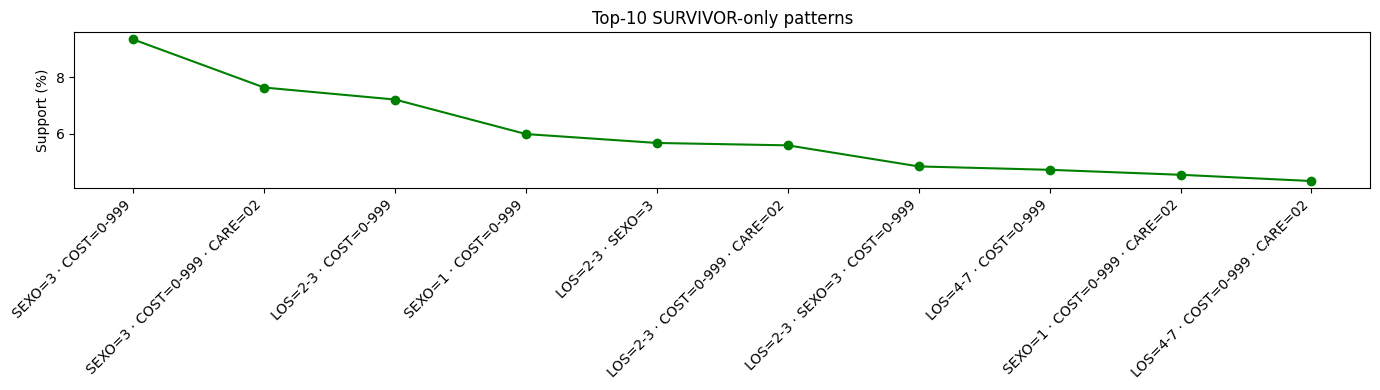

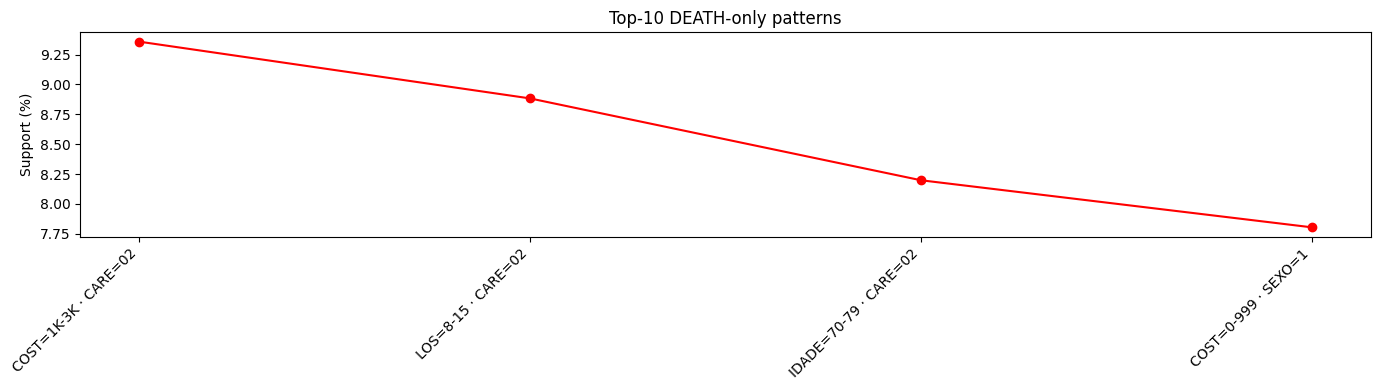

In [35]:


df_mort = df_pat_mort
df_surv = df_pat_surv


n_mort = df_mort['count'].sum()
n_surv = df_surv['count'].sum()


df_mort['support_pct'] = df_mort['count'] / n_mort * 100
df_surv['support_pct'] = df_surv['count'] / n_surv * 100


set_mort, set_surv = set(df_mort['items']), set(df_surv['items'])
common_items       = set_mort & set_surv
mort_only_items    = set_mort - set_surv
surv_only_items    = set_surv - set_mort

df_common = pd.merge(
        df_mort[df_mort['items'].isin(common_items)][['items','support_pct']],
        df_surv[df_surv['items'].isin(common_items)][['items','support_pct']],
        on='items', how='inner', suffixes=('_mort','_surv')
)

df_mort_only = (df_mort[df_mort['items'].isin(mort_only_items)]
                .nlargest(10, 'support_pct'))
df_surv_only = (df_surv[df_surv['items'].isin(surv_only_items)]
                .nlargest(10, 'support_pct'))

short = lambda tpl: ' · '.join(tpl)


#   COMMON PATTERNS — line plot

plt.figure(figsize=(14,5))
x = range(len(df_common))

plt.plot(x, df_common['support_pct_mort'], marker='o', color='red',   label='Deaths')
plt.plot(x, df_common['support_pct_surv'], marker='o', color='green', label='Survivors')

plt.xticks(x, [short(t) for t in df_common['items']], rotation=45, ha='right')
plt.ylabel('Support (%)')
plt.title('Patterns present in BOTH groups')
plt.legend()
plt.tight_layout()
plt.show()


#  SURVIVOR-ONLY — top-10 line plot

plt.figure(figsize=(14,4))
x = range(len(df_surv_only))
plt.plot(x, df_surv_only['support_pct'], marker='o', color='green')
plt.xticks(x, [short(t) for t in df_surv_only['items']], rotation=45, ha='right')
plt.ylabel('Support (%)')
plt.title('Top-10 SURVIVOR-only patterns')
plt.tight_layout()
plt.show()


#   DEATH-ONLY — top-10 line plot

plt.figure(figsize=(14,4))
x = range(len(df_mort_only))
plt.plot(x, df_mort_only['support_pct'], marker='o', color='red')
plt.xticks(x, [short(t) for t in df_mort_only['items']], rotation=45, ha='right')
plt.ylabel('Support (%)')
plt.title('Top-10 DEATH-only patterns')
plt.tight_layout()
plt.show()


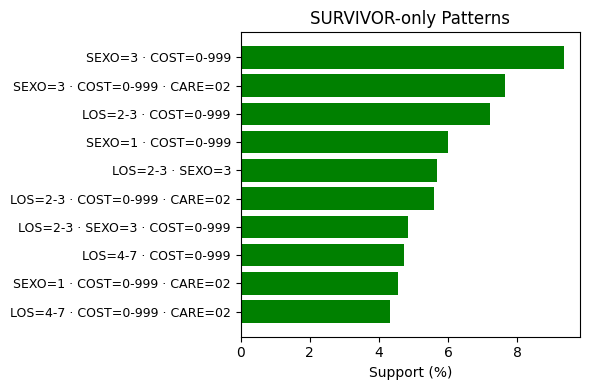

In [57]:
plt.figure(figsize=(6, 4))


y = range(len(df_surv_only))
plt.barh(y, df_surv_only['support_pct'], color='green')
plt.yticks(y, [short(t) for t in df_surv_only['items']], fontsize=9)

plt.xlabel('Support (%)')
plt.title('SURVIVOR-only Patterns')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


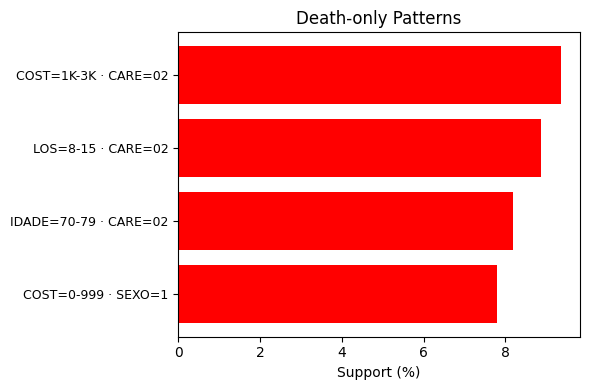

In [61]:
plt.figure(figsize=(6, 4))


y = range(len(df_mort_only))
plt.barh(y, df_mort_only['support_pct'], color='red')
plt.yticks(y, [short(t) for t in df_mort_only['items']], fontsize=9)

plt.xlabel('Support (%)')
plt.title('Death-only Patterns')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# compare patterns across sexo and idade

In [36]:


target_rows = 34_000_000
sample_size = min(target_rows, len(df_filtrado))
df_samp = df_filtrado.sample(n=sample_size, random_state=42)

print(f"Sample size: {len(df_samp):,} rows")


mort_counts = (
    df_samp['MORTE']
      .value_counts(dropna=False)
      .rename({0: 'Survivors (MORTE=0)',
               1: 'Deaths (MORTE=1)'})
      .to_frame(name='rows')
)

mort_counts['share_%'] = (mort_counts['rows'] / sample_size * 100).round(2)
print("\nMORTE distribution in sample")
print(mort_counts)


#  Prepare labels for SEXO

sexo_map = {1: 'Male', 3: 'Female'}
df_samp['SEXO_LABEL'] = df_samp['SEXO'].map(sexo_map).fillna(df_samp['SEXO'].astype(str))




# modal COST band per Age × Sex
pivot_cost = pd.pivot_table(df_samp,
                            values='VAL_CAT',
                            index='IDADE_CAT',
                            columns='SEXO_LABEL',
                            aggfunc=lambda x: x.value_counts().idxmax())

# modal LOS band per Age × Sex
pivot_los = pd.pivot_table(df_samp,
                           values='PERM_CAT',
                           index='IDADE_CAT',
                           columns='SEXO_LABEL',
                           aggfunc=lambda x: x.value_counts().idxmax())

# mortality rate (%)
mort_rate = (
    df_samp
      .groupby(['IDADE_CAT', 'SEXO_LABEL'])['MORTE']
      .mean()
      * 100
).unstack()

# 5.  Display tables

print("\nModal COST band (VAL_CAT) by Age × Sex")
display(pivot_cost)

print("\nModal Length-of-Stay band (PERM_CAT) by Age × Sex")
display(pivot_los)

print("\nMortality rate (% admissions that died) by Age × Sex")
display(mort_rate.round(2))




Sample size: 34,000,000 rows

MORTE distribution in sample
                         rows  share_%
MORTE                                 
Survivors (MORTE=0)  32326160    95.08
Deaths (MORTE=1)      1673840     4.92


/tmp/ipython-input-36-1543324781.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_cost = pd.pivot_table(df_samp,
/tmp/ipython-input-36-1543324781.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_los = pd.pivot_table(df_samp,
/tmp/ipython-input-36-1543324781.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['IDADE_CAT', 'SEXO_LABEL'])['MORTE']



Modal COST band (VAL_CAT) by Age × Sex


SEXO_LABEL,1,3
IDADE_CAT,,
0-9,0-999,0-999
10-19,0-999,0-999
20-29,0-999,0-999
30-39,0-999,0-999
40-49,0-999,0-999
50-59,0-999,0-999
60-69,0-999,0-999
70-79,0-999,0-999
80-89,0-999,0-999



Modal Length-of-Stay band (PERM_CAT) by Age × Sex


SEXO_LABEL,1,3
IDADE_CAT,,
0-9,4-7,4-7
10-19,2-3,2-3
20-29,2-3,2-3
30-39,2-3,2-3
40-49,2-3,2-3
50-59,2-3,2-3
60-69,2-3,2-3
70-79,4-7,4-7
80-89,4-7,4-7



Mortality rate (% admissions that died) by Age × Sex


SEXO_LABEL,1,3
IDADE_CAT,,
0-9,1.54,1.83
10-19,0.87,0.45
20-29,1.71,0.29
30-39,2.37,0.70
40-49,3.73,2.27
50-59,5.87,4.64
60-69,8.52,7.51
70-79,12.07,11.07
80-89,17.58,16.87


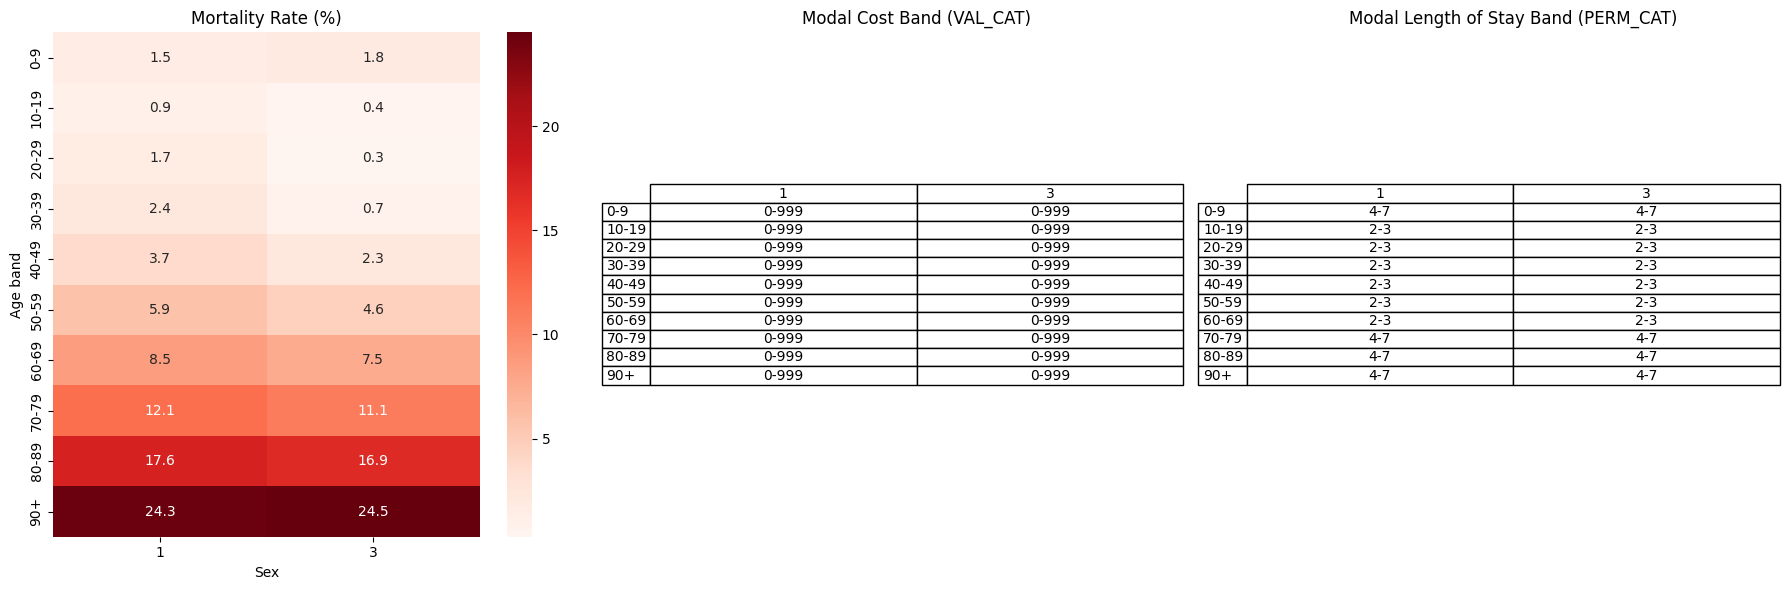

In [37]:

#  Heatmap for Mortality + Annotated Text Grids for Band Modes

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#  Mortality Rate (numerical)
sns.heatmap(mort_rate.sort_index(), annot=True, fmt=".1f",
            cmap='Reds', ax=axes[0])
axes[0].set_title("Mortality Rate (%)")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Age band")

# Cost Band Grid (categorical)
axes[1].axis('off')
table_cost = pd.DataFrame(pivot_cost).sort_index()
axes[1].table(cellText=table_cost.values,
              rowLabels=table_cost.index,
              colLabels=table_cost.columns,
              cellLoc='center', loc='center')
axes[1].set_title("Modal Cost Band (VAL_CAT)")

#  Length of Stay Grid (categorical)
axes[2].axis('off')
table_los = pd.DataFrame(pivot_los).sort_index()
axes[2].table(cellText=table_los.values,
              rowLabels=table_los.index,
              colLabels=table_los.columns,
              cellLoc='center', loc='center')
axes[2].set_title("Modal Length of Stay Band (PERM_CAT)")

plt.tight_layout()
plt.show()


In [38]:
mort_counts = (
    df_filtrado['MORTE']
      .value_counts(dropna=False)
      .rename({0: 'Survivors (MORTE=0)',
               1: 'Deaths (MORTE=1)'})
      .to_frame(name='rows')
)

mort_counts['share_%'] = (mort_counts['rows'] / sample_size * 100).round(2)
print("\nMORTE distribution in sample")
print(mort_counts)


MORTE distribution in sample
                         rows  share_%
MORTE                                 
Survivors (MORTE=0)  75369865   221.68
Deaths (MORTE=1)      3899092    11.47


In [39]:
df_common.shape

(5, 3)

In [40]:
df_common

,items,support_pct_mort,support_pct_surv
0,"(SEXO=1, CARE=02)",18.608646,6.671193
1,"(SEXO=3, CARE=02)",16.154158,9.555662
2,"(COST=0-999, CARE=02)",14.090421,12.173193
3,"(LOS=4-7, CARE=02)",9.067488,5.534781
4,"(LOS=2-3, CARE=02)",7.836029,6.239881


In [41]:
df_common['support_diff'] = df_common['support_pct_mort'] - df_common['support_pct_surv']
df_common.sort_values('support_diff', ascending=False).head(10)


,items,support_pct_mort,support_pct_surv,support_diff
0,"(SEXO=1, CARE=02)",18.608646,6.671193,11.937452
1,"(SEXO=3, CARE=02)",16.154158,9.555662,6.598496
3,"(LOS=4-7, CARE=02)",9.067488,5.534781,3.532707
2,"(COST=0-999, CARE=02)",14.090421,12.173193,1.917228
4,"(LOS=2-3, CARE=02)",7.836029,6.239881,1.596147


#Subgroup Discovery

In [42]:
!pip install pysubgroup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 2.5 MB/s eta 0:00:00


In [43]:
import pysubgroup as ps
import sys

In [44]:
df_sample = df_filtrado.sample(frac=0.01, random_state=42)
print(df_sample.shape)

(792690, 11)


In [45]:
df_sample.drop(columns=['IDADE', 'DIAS_PERM', 'VAL_TOT'], inplace=True)
df_sample.head()

,SEXO,CAR_INT,UF_ZI,DIAG_PRINC,MORTE,IDADE_CAT,PERM_CAT,VAL_CAT
78043623,1,02,350000,J180,0,70-79,2-3,0-999
60005845,1,02,210000,L88,0,0-9,4-7,0-999
19322028,3,02,290000,K429,0,10-19,2-3,0-999
52117776,3,01,330455,F201,0,30-39,16-30,0-999
67437003,1,01,312800,Z302,0,50-59,2-3,0-999


In [46]:
target = ps.BinaryTarget ('MORTE', 1)
searchspace = ps.create_selectors(df_sample, ignore=['MORTE'])
task = ps.SubgroupDiscoveryTask (
    df_sample,
    target,
    searchspace,
    result_set_size=5,
    depth=2,
    qf=ps.WRAccQF())
result = ps.DFS().execute(task)

In [47]:
subgroupdf = result.to_dataframe()

In [48]:
subgroupdf.head()

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.008380,CAR_INT=='02' AND SEXO=='1',256781,792690,19219,38824,535909,0.323936,0.676064,0.495029,0.504971,0.074846,0.036583,0.048978,1.528168
1,0.007236,CAR_INT=='02',613440,792690,35781,38824,179250,0.773871,0.226129,0.921621,0.078379,0.058328,0.016976,0.048978,1.190922
2,0.006987,IDADE_CAT=='80-89',45392,792690,7762,38824,747298,0.057263,0.942737,0.199928,0.800072,0.170999,0.041566,0.048978,3.491382
3,0.006919,CAR_INT=='02' AND IDADE_CAT=='70-79',59754,792690,8411,38824,732936,0.075381,0.924619,0.216644,0.783356,0.140760,0.041495,0.048978,2.873980
4,0.006782,CAR_INT=='02' AND IDADE_CAT=='80-89',38522,792690,7263,38824,754168,0.048597,0.951403,0.187075,0.812925,0.188542,0.041849,0.048978,3.849553


In [66]:
target = ps.BinaryTarget('VAL_CAT', '30K+')
searchspace = ps.create_selectors(df_sample, ignore=['VAL_CAT'])
task = ps.SubgroupDiscoveryTask (
    df_sample,
    target,
    searchspace,
    result_set_size=5,
    depth=3,
    qf=ps.WRAccQF())

result = ps.DFS().execute(task)
result_dataframe_cost = result.to_dataframe()

In [68]:
#Plotting results
result_dataframe_cost

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.001075,PERM_CAT=='31+',20005,792690,918,2599,772685,0.025237,0.974763,0.353213,0.646787,0.045889,0.002176,0.003279,13.995913
1,0.000972,CAR_INT=='02' AND PERM_CAT=='31+',14383,792690,818,2599,778307,0.018145,0.981855,0.314736,0.685264,0.056873,0.002288,0.003279,17.346063
2,0.000796,PERM_CAT=='16-30',44151,792690,776,2599,748539,0.055698,0.944302,0.298576,0.701424,0.017576,0.002435,0.003279,5.360660
3,0.000789,DIAG_PRINC=='B342',18834,792690,687,2599,773856,0.023760,0.976240,0.264332,0.735668,0.036477,0.002471,0.003279,11.125288
4,0.000746,CAR_INT=='02' AND DIAG_PRINC=='B342',17697,792690,649,2599,774993,0.022325,0.977675,0.249711,0.750289,0.036673,0.002516,0.003279,11.185159
